<ipython-input-2-e96bfdfb4248>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


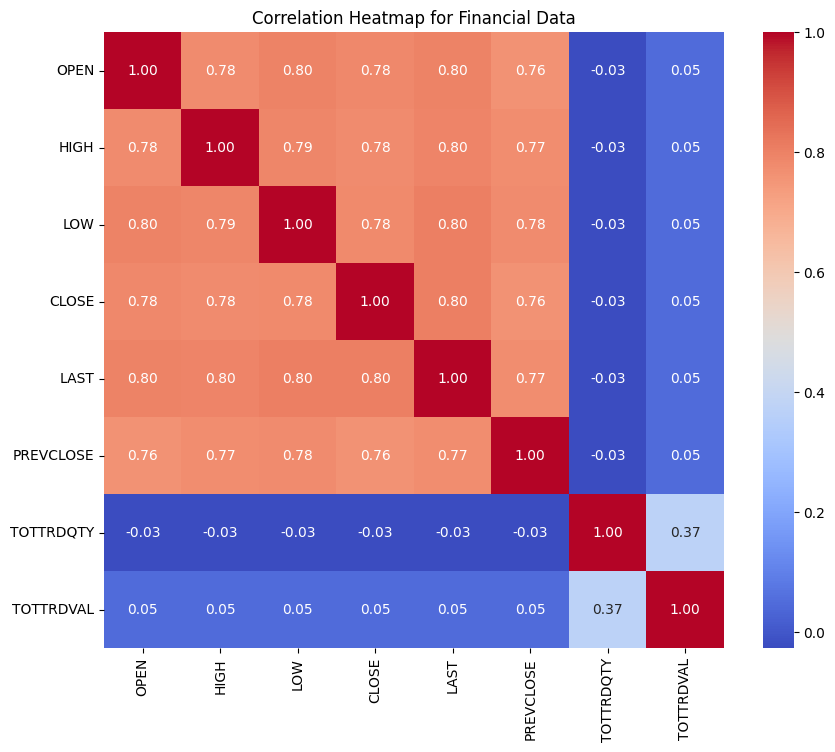

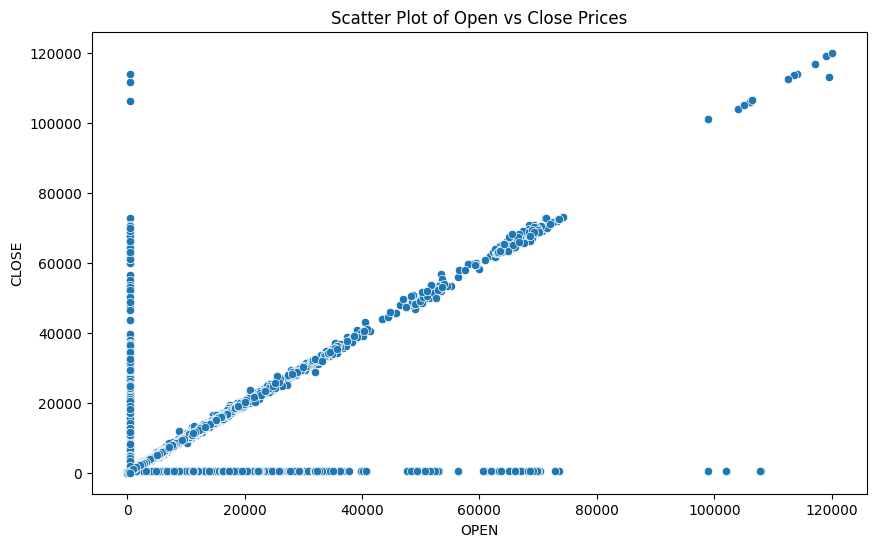

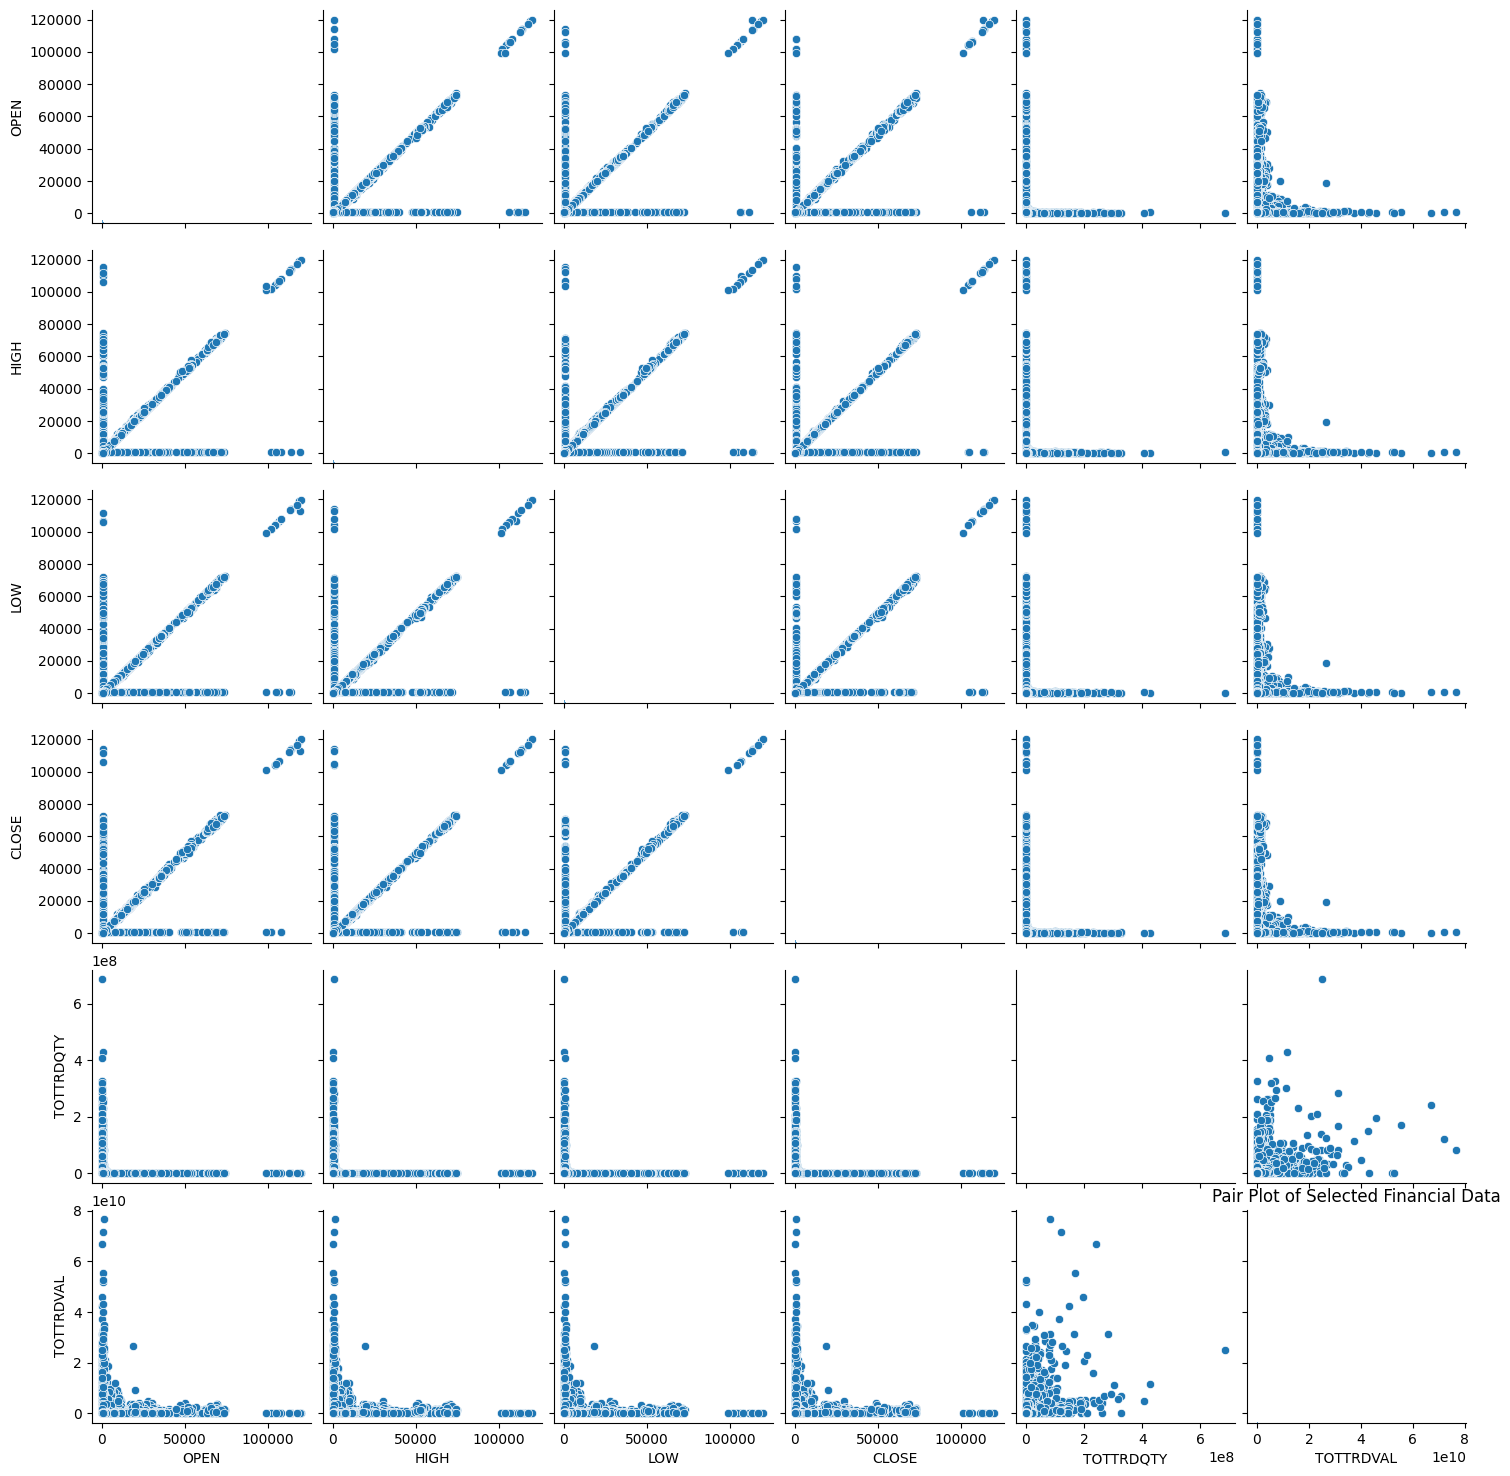

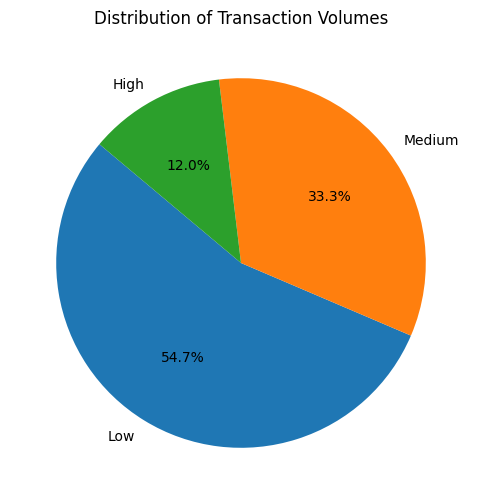

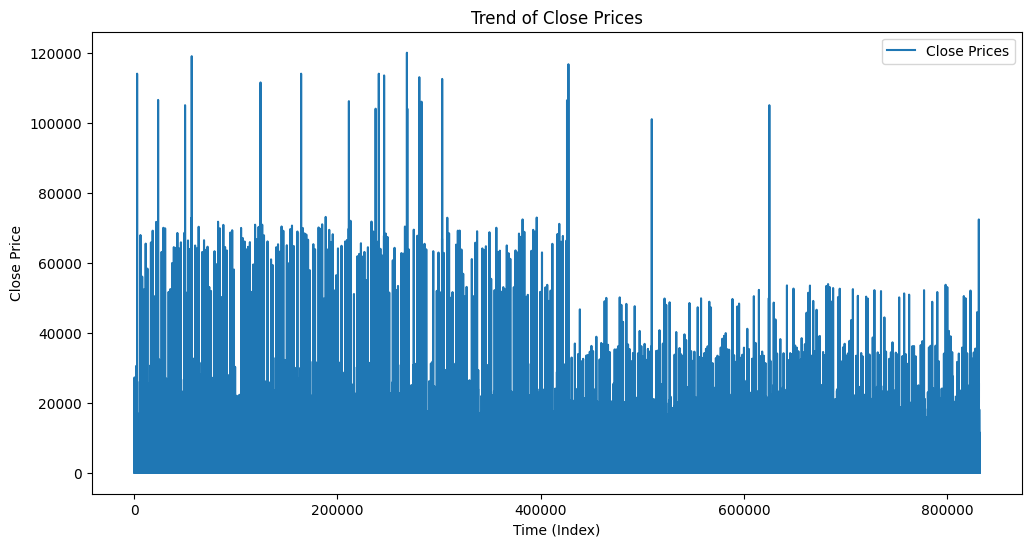

Cleaned data saved to: /content/clean data.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/final data.csv'
data = pd.read_csv(file_path)

# Data Cleaning
data.replace('NaN', np.nan, inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Select numeric columns only, assuming they need absolute value treatment
numeric_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'LAST', 'PREVCLOSE', 'TOTTRDQTY', 'TOTTRDVAL']
data[numeric_cols] = data[numeric_cols].abs()

# Remove duplicates
data.drop_duplicates(inplace=True)

# Drop rows with too many missing values
threshold = len(data.columns) * 0.5  # Example threshold: 50% of the columns
data.dropna(thresh=threshold, inplace=True)

# Fill missing values with the mean or median
for col in numeric_cols:
    data[col].fillna(data[col].mean(), inplace=True)

# Save the cleaned data to a new CSV file
output_path = '/content/clean data.csv'
data.to_csv(output_path, index=False)

# Correlation heatmap for numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap for Financial Data')
plt.show()

# Scatter plot of OPEN vs CLOSE prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x='OPEN', y='CLOSE', data=data)
plt.title('Scatter Plot of Open vs Close Prices')
plt.show()

# Pair Plot for selected financial data
selected_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TOTTRDQTY', 'TOTTRDVAL']
sns.pairplot(data[selected_cols])
plt.title('Pair Plot of Selected Financial Data')
plt.show()

# Pie Chart for distribution of a specific numeric attribute (e.g., distribution of transaction volumes)
transaction_labels = ['Low', 'Medium', 'High']
data['Volume Category'] = pd.qcut(data['TOTTRDQTY'], q=3, labels=transaction_labels)
volume_counts = data['Volume Category'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(volume_counts, labels=transaction_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Transaction Volumes')
plt.show()

# Line Plot for the 'CLOSE' prices to view trend
plt.figure(figsize=(12, 6))
plt.plot(data['CLOSE'].values, label='Close Prices')
plt.title('Trend of Close Prices')
plt.xlabel('Time (Index)')
plt.ylabel('Close Price')
plt.legend()
plt.show()

print(f"Cleaned data saved to: {output_path}")

## KNN Snippet-Wise Codes

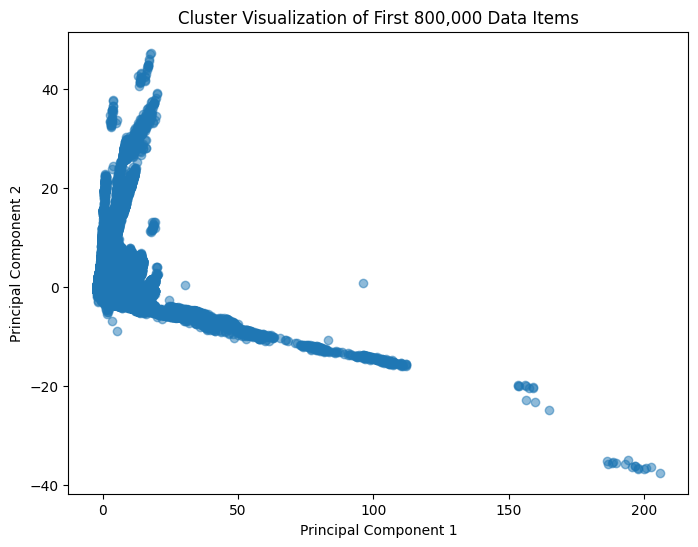

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load your data
data = pd.read_csv('/content/FINAL_FROM_DF.csv')

# Data preprocessing
data.dropna(inplace=True)

# Define periods for technical indicators used as features
rsi_period = 14
cci_period = 20
roc_period = 12
ema_short_period = 12
ema_long_period = 26
bollinger_period = 20

# Feature Engineering: calculations for technical indicators
data['Price Change'] = data['CLOSE'].diff()
data['Typical Price'] = (data['HIGH'] + data['LOW'] + data['CLOSE']) / 3
data['Mean Deviation'] = np.abs(data['Typical Price'] - data['Typical Price'].rolling(window=cci_period).mean())
data['Avg Gain'] = data['Price Change'].apply(lambda x: x if x > 0 else 0).rolling(window=rsi_period).mean()
data['Avg Loss'] = (-data['Price Change']).apply(lambda x: x if x > 0 else 0).rolling(window=rsi_period).mean()
data['RS'] = data['Avg Gain'] / data['Avg Loss']
data['RSI'] = 100 - (100 / (1 + data['RS']))
data['CCI'] = (data['Typical Price'] - data['Typical Price'].rolling(window=cci_period).mean()) / (0.015 * data['Mean Deviation'])
data['ROC'] = ((data['CLOSE'] - data['CLOSE'].shift(roc_period)) / data['CLOSE'].shift(roc_period)) * 100
data['EMA12'] = data['CLOSE'].ewm(span=ema_short_period, adjust=False).mean()
data['EMA26'] = data['CLOSE'].ewm(span=ema_long_period, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['BB_Middle'] = data['CLOSE'].rolling(window=bollinger_period).mean()
data['BB_Upper'] = data['BB_Middle'] + (2 * data['CLOSE'].rolling(window=bollinger_period).std())
data['BB_Lower'] = data['BB_Middle'] - (2 * data['CLOSE'].rolling(window=bollinger_period).std())
data['Momentum'] = data['CLOSE'] - data['CLOSE'].shift(10)
data['Label'] = np.sign(data['CLOSE'].diff().shift(-1))
data.dropna(inplace=True)

# Select numeric features only
numeric_features = data.select_dtypes(include=[np.number])

# For visualization, select the first 800,000 data items
features = numeric_features.iloc[:800000, :]

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA for dimension reduction to 2D
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.5)
plt.title('Cluster Visualization of First 800,000 Data Items')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# Continuing from the previous snippet...

# Selecting features for the entire dataset for training
all_features = data[['RSI', 'CCI', 'ROC', 'TOTTRDQTY', 'MACD', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'EMA12', 'Momentum']]
labels = data['Label']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(all_features, labels, test_size=0.2, random_state=42)

# Train KNN model
from sklearn.neighbors import KNeighborsClassifier
k = 5  # Optimized k value (previously determined or tested through cross-validation)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(train_features, train_labels)

# Predict and show results
predictions = model.predict(test_features)
comparison_df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
print(comparison_df.head())


        Actual  Predicted
346957    -1.0        1.0
693372    -1.0       -1.0
38119      1.0       -1.0
185682     1.0        1.0
832874     1.0        1.0


In [ ]:
# Continuing from the previous snippet...

# Evaluate model accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions)
accuracy_pct = "%.2f" % (accuracy * 100)
print('Accuracy of the model:', accuracy)
print('Percentage Accuracy of the model: ', accuracy_pct, '%')


Accuracy of the model: 0.6905489791807378
Percentage Accuracy of the model:  69.05 %


## Logistic Regression Snippet-Wise Codes

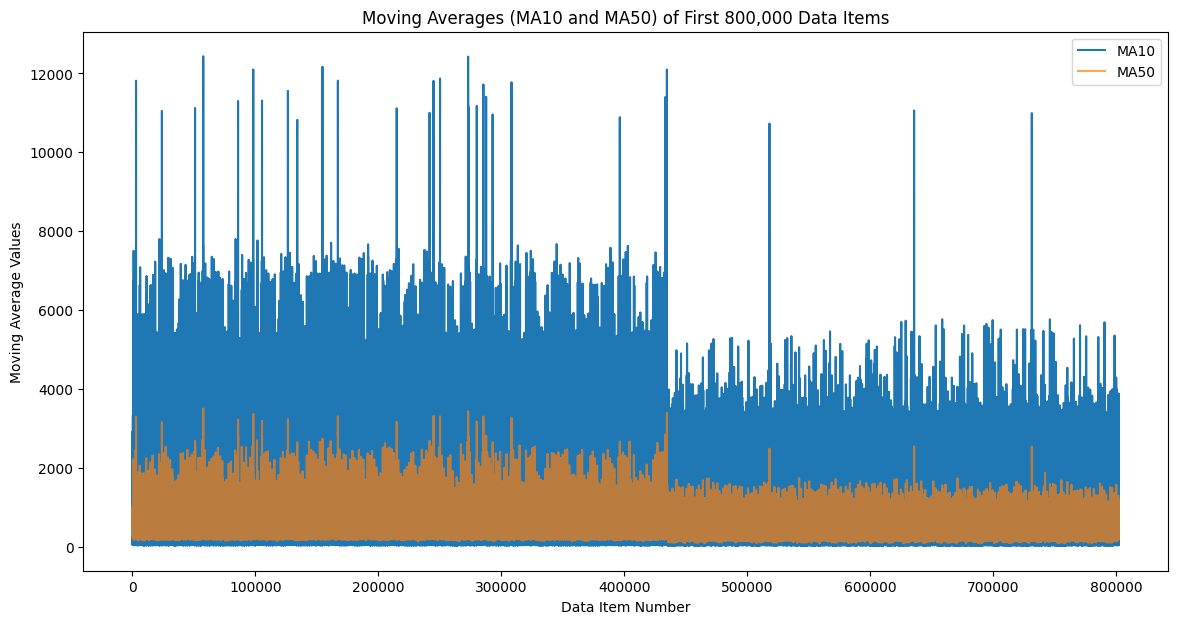

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/content/FINAL_FROM_DF.csv')

# Data preprocessing and feature engineering
data['Price Change'] = data['CLOSE'].diff()
data['MA10'] = data['CLOSE'].rolling(window=10).mean()
data['MA50'] = data['CLOSE'].rolling(window=50).mean()

# Remove NaNs for visualization
data.dropna(inplace=True)

# Visualization of first 800,000 data items for key features
plt.figure(figsize=(14, 7))
plt.plot(data['MA10'].iloc[:800000], label='MA10')
plt.plot(data['MA50'].iloc[:800000], label='MA50', alpha=0.7)
plt.title('Moving Averages (MA10 and MA50) of First 800,000 Data Items')
plt.xlabel('Data Item Number')
plt.ylabel('Moving Average Values')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit as sigmoid  # Logistic function
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv('/content/FINAL_FROM_DF.csv')

# Data preprocessing and feature engineering
data['Price Change'] = data['CLOSE'].diff()
data['MA10'] = data['CLOSE'].rolling(window=10).mean()
data['MA50'] = data['CLOSE'].rolling(window=50).mean()
data['MA20'] = data['CLOSE'].rolling(window=20).mean()  # Moving Average for Bollinger Bands
data['RSI'] = 100 - (100 / (1 + data['CLOSE'].diff().apply(lambda x: max(x, 0)).rolling(window=14).mean() /
                          data['CLOSE'].diff().apply(lambda x: max(-x, 0)).rolling(window=14).mean()))
data['MACD'] = data['CLOSE'].ewm(span=12, adjust=False).mean() - data['CLOSE'].ewm(span=26, adjust=False).mean()
data['Bollinger_Up'] = data['MA20'] + 2 * data['CLOSE'].rolling(window=20).std()
data['Bollinger_Down'] = data['MA20'] - 2 * data['CLOSE'].rolling(window=20).std()
data['Momentum'] = data['CLOSE'] - data['CLOSE'].shift(10)
data['Volatility'] = data['CLOSE'].rolling(window=10).std()
data['Pct_Change'] = data['CLOSE'].pct_change()

# Remove NaNs and prepare features and target
data.dropna(inplace=True)
features = data[['Price Change', 'MA10', 'MA50', 'RSI', 'MACD', 'Bollinger_Up', 'Bollinger_Down', 'Momentum', 'Volatility', 'Pct_Change']]
target = (data['CLOSE'].shift(-1) > data['CLOSE']).astype(int)  # 1 if the price will go up, 0 otherwise

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Define the logistic regression model function
def logistic_regression(X, Y, lr, iterations):
    w = np.zeros(X.shape[1])
    for _ in range(iterations):
        hypothesis = sigmoid(np.dot(X, w))
        gradient = np.dot(X.T, (hypothesis - Y)) / Y.size
        w -= lr * gradient
    return w

# Train the model
lrate = 0.0009
iterations = 1000
weights = logistic_regression(X_train, y_train, lrate, iterations)

# Predict function
def predict(X, weights):
    return sigmoid(np.dot(X, weights)) > 0.5

# Model predictions
predictions = predict(X_test, weights)
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.astype(int)})
print(comparison_df.head())


        Actual  Predicted
786097       0          0
313134       1          0
415814       0          0
76767        0          0
707989       0          0


In [ ]:
from sklearn.metrics import accuracy_score
# Model evaluation
accuracy = accuracy_score(y_test, predictions)
accuracy_pct = "%.2f" % (accuracy * 100)

print('Accuracy of the model:', accuracy)
print('Percentage Accuracy of the model: ', accuracy_pct, '%')

Accuracy of the model: 0.5609985385314216
Percentage Accuracy of the model:  56.10 %


## Gaussian Naive-Bayes Snippet-Wise Codes

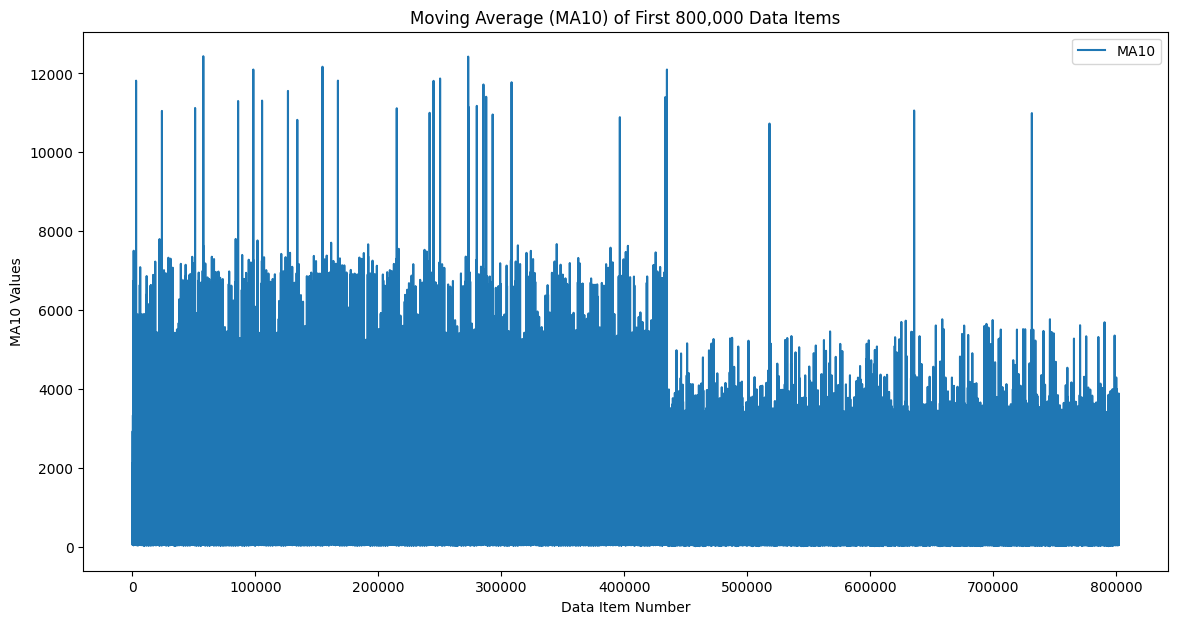

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/content/FINAL_FROM_DF.csv')

# Data preprocessing (continuing the preprocessing from previous examples)
data['Price Change'] = data['CLOSE'].diff()
data['MA10'] = data['CLOSE'].rolling(window=10).mean()

# Remove NaNs for visualization
data.dropna(inplace=True)

# Visualization of first 800,000 data items for key features
plt.figure(figsize=(14, 7))
plt.plot(data['MA10'].iloc[:800000], label='MA10')
plt.title('Moving Average (MA10) of First 800,000 Data Items')
plt.xlabel('Data Item Number')
plt.ylabel('MA10 Values')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Assuming continuation from above preprocessing...

# Further feature engineering if necessary (Assuming features array is prepared as above)
features = data[['Price Change', 'MA10']]  # Example features, adjust based on your specific data

# Prepare the target variable
target = (data['CLOSE'].shift(-1) > data['CLOSE']).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Train the Naive-Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Display predictions alongside actual values in a DataFrame
import pandas as pd
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(comparison_df.head())

        Actual  Predicted
419815       1          1
178541       1          1
646015       0          1
626349       1          1
46716        0          1


In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate model accuracy
accuracy = accuracy_score(y_test, predictions)
accuracy_pct = "%.2f" % (accuracy * 100)

print('Accuracy of the model:', accuracy)
print('Percentage Accuracy of the model: ', accuracy_pct, '%')

Accuracy of the model: 0.5401924307415219
Percentage Accuracy of the model:  54.02 %


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from scipy.special import expit as sigmoid  # Logistic function may be required for Logistic Regression implementation
from time import sleep


data = pd.read_csv('/content/FINAL_FROM_DF.csv')

# Preprocess the dataset
def preprocess_data(data, numeric_cols):
    data[numeric_cols] = data[numeric_cols].abs()
    data.drop_duplicates(inplace=True)
    threshold = len(data.columns) * 0.5
    data.dropna(thresh=threshold, inplace=True)
    for col in numeric_cols:
        if data[col].isna().any():
            data[col].fillna(data[col].mean(), inplace=True)
    return data

# Run K-Nearest Neighbors model
def run_knn(data):
    numeric_features = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(numeric_features)
    labels = (data['CLOSE'].shift(-1) > data['CLOSE']).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return predictions, accuracy

# Run Logistic Regression model
def run_logistic_regression(data):
    features = data[['OPEN', 'HIGH', 'LOW', 'CLOSE']]
    labels = (data['CLOSE'].shift(-1) > data['CLOSE']).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return predictions, accuracy

# Run Gaussian Naive Bayes model
def run_naive_bayes(data):
    features = data[['OPEN', 'HIGH', 'LOW', 'CLOSE']]
    labels = (data['CLOSE'].shift(-1) > data['CLOSE']).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
    model = GaussianNB()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return predictions, accuracy

# Main function
def main():
    # filepath = 'your_dataset.csv'  # Update to your dataset's filepath
    # data = load_data(filepath)
    data = pd.read_csv('/content/FINAL_FROM_DF.csv')
    numeric_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'LAST', 'PREVCLOSE', 'TOTTRDQTY', 'TOTTRDVAL']
    data = preprocess_data(data, numeric_cols)

    while True:
        print("\nMenu:")
        print("1 - K-Nearest Neighbor")
        print("2 - Logistic Regression")
        print("3 - Gaussian Naive Bayes")
        print("0 - Exit")
        choice = input("Enter your choice: ")

        if choice == '1':
            print("Model is learning...")
            sleep(8)  # Simulate loading time
            predictions, accuracy = run_knn(data)
            print("Predicted:", predictions)
            print("Accuracy:", accuracy)
            accuracy_pct = "%.2f" % (accuracy * 100)
            print('Percentage Accuracy of the model: ', accuracy_pct, '%')
        elif choice == '2':
            print("Model is learning...")
            sleep(8)
            predictions, accuracy = run_logistic_regression(data)
            print("Predicted:", predictions)
            print("Accuracy:", accuracy)
            accuracy_pct = "%.2f" % (accuracy * 100)
            print('Percentage Accuracy of the model: ', accuracy_pct, '%')
        elif choice == '3':
            print("Model is learning...")
            sleep(8)
            predictions, accuracy = run_naive_bayes(data)
            print("Predicted:", predictions)
            print("Accuracy:", accuracy)
            accuracy_pct = "%.2f" % (accuracy * 100)
            print('Percentage Accuracy of the model: ', accuracy_pct, '%')
        elif choice == '0':
            print("Exiting...")
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()



Menu:
1 - K-Nearest Neighbor
2 - Logistic Regression
3 - Gaussian Naive Bayes
0 - Exit
Enter your choice: 1
Model is learning...
Predicted: [1 1 0 ... 1 0 1]
Accuracy: 0.7033807692534898
Percentage Accuracy of the model:  70.34 %

Menu:
1 - K-Nearest Neighbor
2 - Logistic Regression
3 - Gaussian Naive Bayes
0 - Exit
Enter your choice: 0
Exiting...
